In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
from pysfa import SFA

## Import data

In [2]:
df = pd.read_csv('../data/msfa_data.csv')

## Create object

In [3]:
m = df.shape[0]
s = np.sqrt(df['uhc_variance'].values)
#
x_physicians = np.vstack((np.ones(m), df['physicians'].values)).T
x_nurses = np.vstack((np.ones(m), df['nurses'].values)).T
#
sfa_physicians = SFA(m, x_physicians, s, vtype='exp')
sfa_nurses = SFA(m, x_nurses, s, vtype='exp')
#
sfa_physicians.y = df['uhc'].values
sfa_nurses.y = df['uhc'].values

## Fit data

In [4]:
sfa_physicians.fitMaxl()

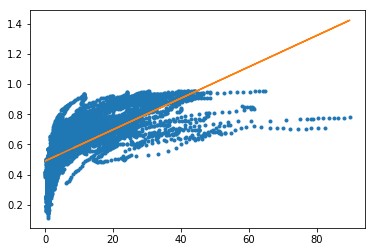

In [5]:
plt.plot(x_physicians[:,1], sfa_physicians.y, '.')
plt.plot(x_physicians[:,1], x_physicians.dot(sfa_physicians.beta_soln) - sfa_physicians.sv_soln, '-')

In [6]:
sfa_physicians.sv_soln

0.08342087014594843

In [7]:
sfa_nurses.fitMaxl()

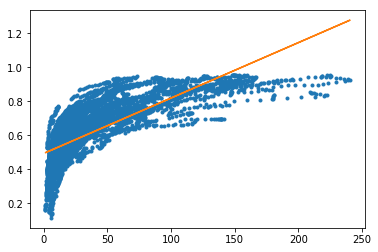

In [8]:
plt.plot(x_nurses[:,1], sfa_nurses.y, '.')
plt.plot(x_nurses[:,1], x_nurses.dot(sfa_nurses.beta_soln) - sfa_nurses.sv_soln, '-')

In [9]:
sfa_nurses.sv_soln

0.07302846903948697